<a href="https://colab.research.google.com/github/Hamaddogar/FIFA-CUP-won-ML-Model/blob/main/ML_FIFA_world_cup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Step 1: Load files
results = pd.read_csv('/content/sample_data/dataset/results.csv')
goals = pd.read_csv('/content/sample_data/dataset/goalscorers.csv')
shoutout = pd.read_csv('/content/sample_data/dataset/shootouts.csv')
former = pd.read_csv('/content/sample_data/dataset/former_names.csv')

# Step 2: Normalize Country Names using 'former_name.csv'
former_dict = dict(zip(former['former'], former['current']))

def normalize_country(name):
    return former_dict.get(name, name)

for col in ['home_team', 'away_team', 'country', 'team']:
    if col in results.columns:
        results[col] = results[col].apply(normalize_country)
    if col in goals.columns:
        goals[col] = goals[col].apply(normalize_country)
    if col in shoutout.columns:
        shoutout[col] = shoutout[col].apply(normalize_country)

# Step 3: Add total goals per match
goals['is_goal'] = 1
goal_counts = goals.groupby(['date', 'team'])['is_goal'].count().reset_index()
goal_counts = goal_counts.pivot(index='date', columns='team', values='is_goal').fillna(0)
goal_counts.reset_index(inplace=True)

# Merge with results
results = results.merge(goal_counts, on='date', how='left')

# Fill missing values
results.fillna(0, inplace=True)

# Step 3.5: Mark if match had a shootout
results['shootout'] = results.apply(lambda row: (
    ((shoutout['date'] == row['date']) &
     (shoutout['home_team'] == row['home_team']) &
     (shoutout['away_team'] == row['away_team']))
).any(), axis=1)

# Step 4: Save cleaned file
results.to_csv('/content/sample_data/dataset/cleaned_results.csv', index=False)

print("✅ Data cleaned and saved as cleaned_results.csv")



✅ Data cleaned and saved as cleaned_results.csv


In [ ]:
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("/content/sample_data/dataset/cleaned_results.csv")

# 1. Basic outcome features
df['goal_difference'] = df['home_score'] - df['away_score']
df['total_goals'] = df['home_score'] + df['away_score']

df['home_win'] = (df['home_score'] > df['away_score']).astype(int)
df['away_win'] = (df['away_score'] > df['home_score']).astype(int)
df['draw'] = (df['home_score'] == df['away_score']).astype(int)
active_teams = set(df['home_team']).union(set(df['away_team']))
df = df[df['home_team'].isin(active_teams) & df['away_team'].isin(active_teams)]

# 2. Match result label (for model)
def result_label(row):
    if row['home_score'] > row['away_score']:
        return 'Home Win'
    elif row['home_score'] < row['away_score']:
        return 'Away Win'
    else:
        return 'Draw'

df['match_result_for_home_team'] = df.apply(result_label, axis=1)

# Optional: Convert date to datetime (important for time-based features later)
df['date'] = pd.to_datetime(df['date'])

# Save enhanced version
df.to_csv("/content/sample_data/dataset/engineered_results.csv", index=False)

print("✅ Feature engineering complete! File saved as engineered_results.csv")


✅ Feature engineering complete! File saved as engineered_results.csv


In [10]:
import pandas as pd

df = pd.read_csv("/content/sample_data/dataset/engineered_results.csv")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
home_df = df[['date', 'year', 'tournament', 'home_team', 'home_score', 'away_score', 'match_result_for_home_team']].copy()
home_df.rename(columns={
    'home_team': 'team',
    'home_score': 'goals_for',
    'away_score': 'goals_against'
}, inplace=True)

home_df['win'] = (home_df['match_result_for_home_team'] == 'Home Win').astype(int)
home_df['draw'] = (home_df['match_result_for_home_team'] == 'Draw').astype(int)
home_df['loss'] = (home_df['match_result_for_home_team'] == 'Away Win').astype(int)

away_df = df[['date', 'year', 'tournament', 'away_team', 'away_score', 'home_score', 'match_result_for_home_team']].copy()
away_df.rename(columns={
    'away_team': 'team',
    'away_score': 'goals_for',
    'home_score': 'goals_against'
}, inplace=True)

# Flip the match result for the away team
away_df['win'] = (away_df['match_result_for_home_team'] == 'Away Win').astype(int)
away_df['draw'] = (away_df['match_result_for_home_team'] == 'Draw').astype(int)
away_df['loss'] = (away_df['match_result_for_home_team'] == 'Home Win').astype(int)

# Combine both
team_match_df = pd.concat([home_df, away_df], ignore_index=True)
team_stats = team_match_df.groupby(['team', 'year', 'tournament']).agg({
    'goals_for': 'sum',
    'goals_against': 'sum',
    'win': 'sum',
    'loss': 'sum',
    'draw': 'sum',
    'date': 'count'  # total matches
}).reset_index()

team_stats.rename(columns={'date': 'matches_played'}, inplace=True)

# Calculate goal difference
team_stats['goal_difference'] = team_stats['goals_for'] - team_stats['goals_against']
# Get last match (final) for each tournament and year
finals = df.sort_values('date').groupby(['year', 'tournament']).tail(1)

finals['winner'] = finals.apply(lambda row: (
    row['home_team'] if row['home_score'] > row['away_score']
    else row['away_team'] if row['away_score'] > row['home_score']
    else None  # or mark Draws separately
), axis=1)

# Merge winner label
team_stats['won_tournament'] = team_stats.apply(lambda row: (
    1 if (
        (row['team'] in finals[
            (finals['year'] == row['year']) &
            (finals['tournament'] == row['tournament'])
        ]['winner'].values)
    ) else 0
), axis=1)
team_stats.to_csv('/content/sample_data/dataset/team_tournament_stats.csv', index=False)
print("📊 Team-level data ready! Saved as team_tournament_stats.csv")



📊 Team-level data ready! Saved as team_tournament_stats.csv


In [12]:
import pandas as pd

df = pd.read_csv("/content/sample_data/dataset/team_tournament_stats.csv")
# 🎯 Target
target = 'won_tournament'

# 🧠 Features
features = ['matches_played', 'goals_for', 'goals_against', 'goal_difference', 'win', 'draw', 'loss']
X = df[features]
y = df[target]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 🧪 Predict on test set
y_pred = model.predict(X_test)

# ✅ Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# precision: how many predicted winners were actually winners

# recall: how many actual winners were predicted correctly

# f1-score: balance of precision & recall

# support: how many samples of each class were teste

Accuracy: 0.9344808439755691
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5094
           1       0.20      0.05      0.08       309

    accuracy                           0.93      5403
   macro avg       0.57      0.52      0.52      5403
weighted avg       0.90      0.93      0.92      5403



In [11]:
# Example: hypothetical 2025 team stats  it hard coded data
fifa_2025 = pd.DataFrame([
    {'team': 'Argentina', 'matches_played': 7, 'goals_for': 12, 'goals_against': 4, 'goal_difference': 8, 'win': 6, 'draw': 1, 'loss': 0},
    {'team': 'France', 'matches_played': 7, 'goals_for': 11, 'goals_against': 5, 'goal_difference': 6, 'win': 5, 'draw': 2, 'loss': 0},
     {'team': 'Brazil', 'matches_played': 7, 'goals_for': 13, 'goals_against': 5, 'goal_difference': 8, 'win': 5, 'draw': 1, 'loss': 1},
])

# Use same features
X_2025 = fifa_2025[features]

# Predict
fifa_2025['winning_probability'] = model.predict_proba(X_2025)[:, 1]  # probability of class "1" = win
fifa_2025['winning_percent'] = (fifa_2025['winning_probability'] * 100).round(2)

# Sort by chance to win
fifa_2025.sort_values('winning_probability', ascending=False, inplace=True)
print(fifa_2025[['team', 'winning_probability', 'winning_percent']])



        team  winning_probability  winning_percent
0  Argentina             0.612429            61.24
1     France             0.100750            10.08
2     Brazil             0.000000             0.00


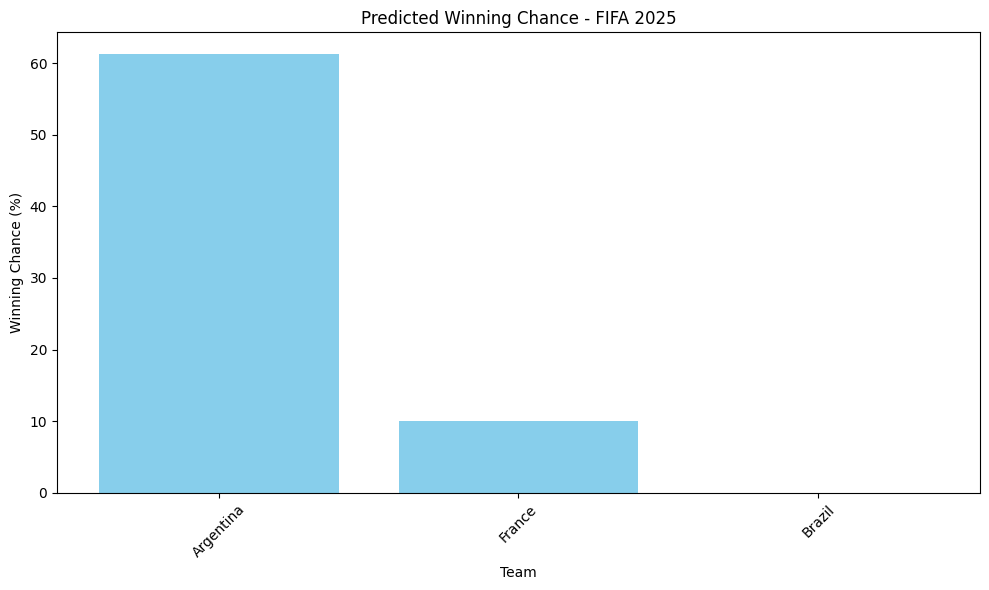

In [13]:
import matplotlib.pyplot as plt

# Plot team winning percent
plt.figure(figsize=(10, 6))
plt.bar(fifa_2025['team'], fifa_2025['winning_percent'], color='skyblue')
plt.xlabel('Team')
plt.ylabel('Winning Chance (%)')
plt.title('Predicted Winning Chance - FIFA 2025')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
